# Project: Combined cycle power plant performance

## Conclusion: XGBoost regression gave best R square score of 96%, random forest - 95.7%.

### Abstract:
The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the plant was set to work with full load.

### Source:

Pınar Tüfekci, Çorlu Faculty of Engineering, Namık Kemal University, TR-59860 Çorlu, Tekirdağ, Turkey
Email: ptufekci '@' nku.edu.tr

Heysem Kaya, Department of Computer Engineering, Boğaziçi University, TR-34342, Beşiktaş, İstanbul, Turkey
Email: heysem '@' boun.edu.tr

https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

### Data Set Information:

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.
For comparability with our baseline studies, and to allow 5x2 fold statistical tests be carried out, we provide the data shuffled five times. For each shuffling 2-fold CV is carried out and the resulting 10 measurements are used for statistical testing.

### Attribute Information:

Features consist of hourly average ambient variables
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.



### Relevant Papers:

Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, [Web Link]. ([Web Link])

Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)

### Citation Request:

Pınar Tüfekci, Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods, International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615, [Web Link].
([Web Link])

Heysem Kaya, Pınar Tüfekci , Sadık Fikret Gürgen: Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine, Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai)



# STEP 1: Learning the dataset and feature engineering

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats # for Q-Q plots

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# importing the dataset
df = pd.read_excel("Folds5x2_pp.xlsx")

Learning the dataset and making feature engineering

In [ ]:
# showing first five rows of the dateset
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [ ]:
# showing the column names
# list(df.columns)

In [ ]:
# showing statistical information about the dataset
# df.info()

In [ ]:
# showing statistical data of the dataset
# df.describe()

In [ ]:
# checking missing values
df.isnull().any(axis = 1).sum()

0

In [ ]:
# checking duplicated rows
df.duplicated().sum()

41

In [ ]:
# deleting the duplicated rows
df.drop_duplicates(inplace=True)

In [ ]:
# checking duplicated rows
df.duplicated().sum()

0

### Exploring the dataset

Visualizing data columns

Exploring distribution, skewness, outliers and other statistical properties

Looking at the distributions of the variables to see which imputation to use

In [ ]:
# function to create histogram, Q-Q plot and boxplot


def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

In [ ]:
# a function for plotting a str column of df and testing for normality

def draw_and_test(str):
    # plotting variable
    diagnostic_plots(df, str)

    # testing for normality
    print(str)
    skewness = df[str].skew()
    print('Skewness is {:.2f}'.format(skewness))
    kurtosis = df[str].kurtosis()
    print('Kurtosis is {:.2f}'.format(kurtosis))

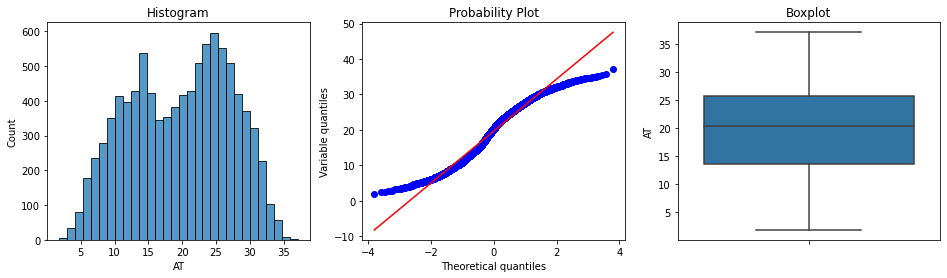

AT
Skewness is -0.14
Kurtosis is -1.03


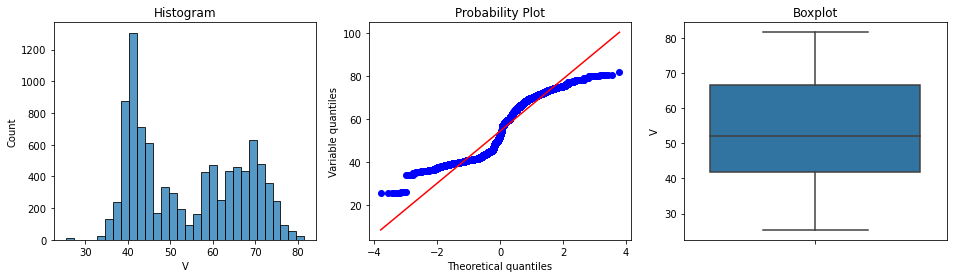

V
Skewness is 0.20
Kurtosis is -1.44


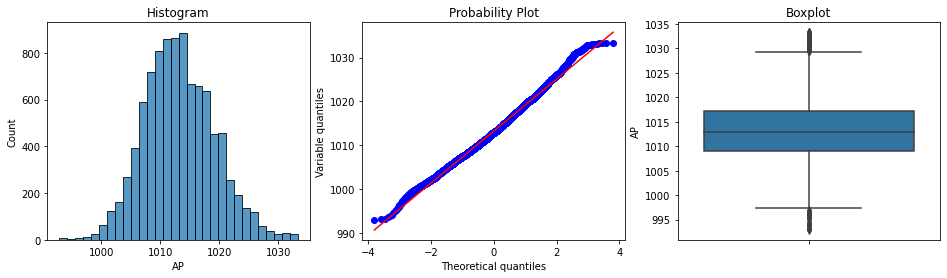

AP
Skewness is 0.27
Kurtosis is 0.10


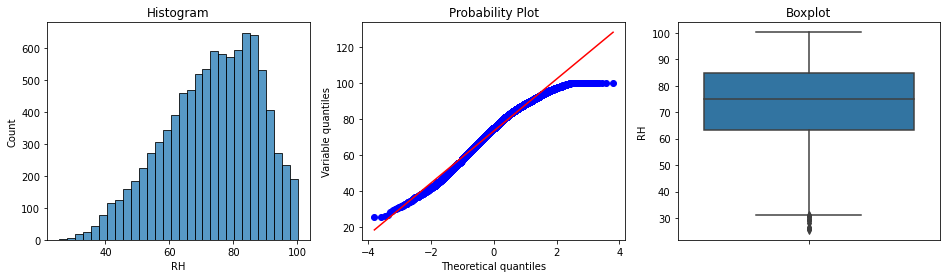

RH
Skewness is -0.44
Kurtosis is -0.44


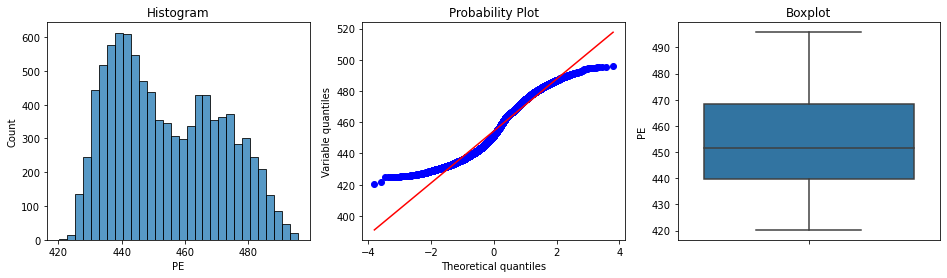

PE
Skewness is 0.31
Kurtosis is -1.05


In [ ]:
# plotting all the variables
for column in df.columns[:]:
    draw_and_test(column)

Discussion: all the variables are well-distributed.

In [ ]:
# calculating a correlation matrix
corr_matrix = df.corr()
print(corr_matrix)

          AT         V        AP        RH        PE
AT  1.000000  0.843689 -0.508222 -0.543947 -0.947908
V   0.843689  1.000000 -0.415718 -0.312214 -0.869900
AP -0.508222 -0.415718  1.000000  0.101631  0.518687
RH -0.543947 -0.312214  0.101631  1.000000  0.391175
PE -0.947908 -0.869900  0.518687  0.391175  1.000000


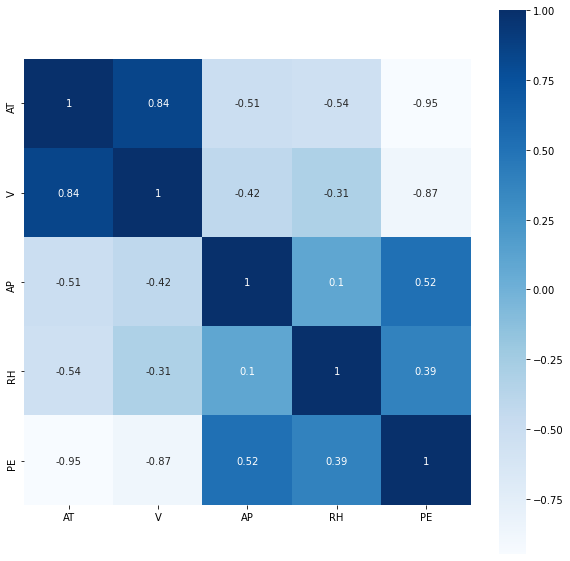

In [ ]:
# drawing a heatmap
plt.figure(figsize = (10,10))
ax = sns.heatmap(corr_matrix, annot=True, square=True, cmap='Blues')
plt.show()

Discussion: all the intependent variables are correlated with the dependent variable

# STEP 2: Choosing best performing regression model

In [ ]:
# separating dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(labels=['PE'], axis=1),  # drop the target
    df['PE'],  # just the target
    test_size=0.3,
    random_state=42)

X_train.shape, X_test.shape

((6668, 4), (2859, 4))

### Linear regression

In [ ]:
# training the multiple linear regression model on the Training set

reg_linear = LinearRegression()
reg_linear.fit(X_train, y_train)

# predicting the Test set results

y_pred = reg_linear.predict(X_test)
r2_score(y_test, y_pred)

0.9259961028887264

### Decision tree regression

In [ ]:
# training the decision tree regression model on the Training set

reg_dt = DecisionTreeRegressor(random_state = 42)
reg_dt.fit(X_train, y_train)

# predicting the Test set results

y_pred = reg_dt.predict(X_test)
r2_score(y_test, y_pred)

0.9261795489076191

### Random forest regression

In [ ]:
# training the random forest regression model on the Training set

reg_rf = RandomForestRegressor(random_state = 42)
reg_rf.fit(X_train, y_train)

# predicting the Test set results

y_pred = reg_rf.predict(X_test)
r2_score(y_test, y_pred)

0.9570400856764162

### XGBoost regression

In [ ]:
# training the XGBoost regression model on the Training set

reg_xgb = XGBRegressor(random_state = 42)
reg_xgb.fit(X_train, y_train)

# predicting the Test set results

y_pred = reg_xgb.predict(X_test)
r2_score(y_test, y_pred)

0.9603520301145945

### ANN

In [ ]:
# importing tensorflow
import tensorflow as tf

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
# initializing the ANN
ann = tf.keras.models.Sequential()

In [ ]:
# showing a shape of X_train array
X_train.shape

(6668, 4)

In [ ]:
# adding the input layer and the first hidden layer
ann.add(tf.keras.layers.Dense(units=4, activation='relu'))

In [ ]:
# adding the second hidden layer
ann.add(tf.keras.layers.Dense(units=1012, activation='sigmoid'))

In [ ]:
# adding the output layer
ann.add(tf.keras.layers.Dense(units=1))

Training the ANN

In [ ]:
# compiling the ANN
ann.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# training the ANN model on the Training set
ann.fit(X_train, y_train, batch_size = 64, epochs = 2000)

Epoch 1/2000

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

105/105 [==============================] - 0s 1ms/step - loss: 166860.2500
Epoch 2/2000
105/105 [==============================] - 0s 923us/step - loss: 107891.6875
Epoch 3/2000
105/105 [==============================] - 0s 1ms/step - loss: 70274.6250
Epoch 4/2000
105/105 [==============================] - 0s 966us/step - loss: 43935.3867
Epoch 5/2000
105/105 [==============================] - 0s 1ms/step - loss: 26165.8965
Epoch 6/2000
105/105 [==============================] - 0s 973us/st

105/105 [==============================] - 0s 904us/step - loss: 35.9586
Epoch 87/2000
105/105 [==============================] - 0s 913us/step - loss: 35.0905
Epoch 88/2000
105/105 [==============================] - 0s 878us/step - loss: 35.7077
Epoch 89/2000
105/105 [==============================] - 0s 859us/step - loss: 34.5004
Epoch 90/2000
105/105 [==============================] - 0s 896us/step - loss: 33.2808
Epoch 91/2000
105/105 [==============================] - 0s 892us/step - loss: 33.3233
Epoch 92/2000
105/105 [==============================] - 0s 882us/step - loss: 33.3356
Epoch 93/2000
105/105 [==============================] - 0s 887us/step - loss: 32.3965
Epoch 94/2000
105/105 [==============================] - 0s 895us/step - loss: 31.3770
Epoch 95/2000
105/105 [==============================] - 0s 889us/step - loss: 31.5224
Epoch 96/2000
105/105 [==============================] - 0s 867us/step - loss: 32.1937
Epoch 97/2000
105/105 [==============================] - 

105/105 [==============================] - 0s 977us/step - loss: 18.9801
Epoch 180/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.3828
Epoch 181/2000
105/105 [==============================] - 0s 912us/step - loss: 19.8329
Epoch 182/2000
105/105 [==============================] - 0s 865us/step - loss: 20.2076
Epoch 183/2000
105/105 [==============================] - 0s 878us/step - loss: 19.5208
Epoch 184/2000
105/105 [==============================] - 0s 894us/step - loss: 19.3594
Epoch 185/2000
105/105 [==============================] - 0s 888us/step - loss: 19.2143
Epoch 186/2000
105/105 [==============================] - 0s 877us/step - loss: 19.3645
Epoch 187/2000
105/105 [==============================] - 0s 902us/step - loss: 19.9693
Epoch 188/2000
105/105 [==============================] - 0s 888us/step - loss: 19.8041
Epoch 189/2000
105/105 [==============================] - 0s 905us/step - loss: 19.8369
Epoch 190/2000
105/105 [=========================

105/105 [==============================] - 0s 955us/step - loss: 18.7768
Epoch 273/2000
105/105 [==============================] - 0s 887us/step - loss: 19.5064
Epoch 274/2000
105/105 [==============================] - 0s 875us/step - loss: 18.6396
Epoch 275/2000
105/105 [==============================] - 0s 903us/step - loss: 18.7113
Epoch 276/2000
105/105 [==============================] - 0s 880us/step - loss: 19.0063
Epoch 277/2000
105/105 [==============================] - 0s 886us/step - loss: 18.7583
Epoch 278/2000
105/105 [==============================] - 0s 904us/step - loss: 18.9857
Epoch 279/2000
105/105 [==============================] - 0s 940us/step - loss: 18.7051
Epoch 280/2000
105/105 [==============================] - 0s 923us/step - loss: 19.1233
Epoch 281/2000
105/105 [==============================] - 0s 867us/step - loss: 18.8222
Epoch 282/2000
105/105 [==============================] - 0s 887us/step - loss: 19.2187
Epoch 283/2000
105/105 [=======================

105/105 [==============================] - 0s 946us/step - loss: 18.9891
Epoch 366/2000
105/105 [==============================] - 0s 882us/step - loss: 19.0474
Epoch 367/2000
105/105 [==============================] - 0s 936us/step - loss: 19.9377
Epoch 368/2000
105/105 [==============================] - 0s 882us/step - loss: 18.4757
Epoch 369/2000
105/105 [==============================] - 0s 890us/step - loss: 19.2057
Epoch 370/2000
105/105 [==============================] - 0s 876us/step - loss: 18.9177
Epoch 371/2000
105/105 [==============================] - 0s 892us/step - loss: 19.0242
Epoch 372/2000
105/105 [==============================] - 0s 882us/step - loss: 18.7542
Epoch 373/2000
105/105 [==============================] - 0s 876us/step - loss: 19.2730
Epoch 374/2000
105/105 [==============================] - 0s 905us/step - loss: 18.9673
Epoch 375/2000
105/105 [==============================] - 0s 910us/step - loss: 19.0836
Epoch 376/2000
105/105 [=======================

105/105 [==============================] - 0s 983us/step - loss: 19.1193
Epoch 459/2000
105/105 [==============================] - 0s 931us/step - loss: 19.0441
Epoch 460/2000
105/105 [==============================] - 0s 886us/step - loss: 18.9335
Epoch 461/2000
105/105 [==============================] - 0s 903us/step - loss: 18.7935
Epoch 462/2000
105/105 [==============================] - 0s 939us/step - loss: 18.7565
Epoch 463/2000
105/105 [==============================] - 0s 916us/step - loss: 18.8605
Epoch 464/2000
105/105 [==============================] - 0s 911us/step - loss: 18.9106
Epoch 465/2000
105/105 [==============================] - 0s 923us/step - loss: 18.8355
Epoch 466/2000
105/105 [==============================] - 0s 894us/step - loss: 18.7597
Epoch 467/2000
105/105 [==============================] - 0s 887us/step - loss: 18.7166
Epoch 468/2000
105/105 [==============================] - 0s 942us/step - loss: 18.6789
Epoch 469/2000
105/105 [=======================

105/105 [==============================] - 0s 892us/step - loss: 18.9028
Epoch 552/2000
105/105 [==============================] - 0s 876us/step - loss: 18.7278
Epoch 553/2000
105/105 [==============================] - 0s 896us/step - loss: 19.0700
Epoch 554/2000
105/105 [==============================] - 0s 910us/step - loss: 18.7644
Epoch 555/2000
105/105 [==============================] - 0s 882us/step - loss: 18.8623
Epoch 556/2000
105/105 [==============================] - 0s 887us/step - loss: 18.7045
Epoch 557/2000
105/105 [==============================] - 0s 886us/step - loss: 18.5920
Epoch 558/2000
105/105 [==============================] - 0s 892us/step - loss: 18.9017
Epoch 559/2000
105/105 [==============================] - 0s 891us/step - loss: 18.6231
Epoch 560/2000
105/105 [==============================] - 0s 877us/step - loss: 18.7348
Epoch 561/2000
105/105 [==============================] - 0s 895us/step - loss: 19.2110
Epoch 562/2000
105/105 [=======================

105/105 [==============================] - 0s 892us/step - loss: 18.6725
Epoch 645/2000
105/105 [==============================] - 0s 878us/step - loss: 18.9168
Epoch 646/2000
105/105 [==============================] - 0s 884us/step - loss: 19.3392
Epoch 647/2000
105/105 [==============================] - 0s 906us/step - loss: 19.1133
Epoch 648/2000
105/105 [==============================] - 0s 897us/step - loss: 18.9543
Epoch 649/2000
105/105 [==============================] - 0s 872us/step - loss: 18.7565
Epoch 650/2000
105/105 [==============================] - 0s 881us/step - loss: 18.7265
Epoch 651/2000
105/105 [==============================] - 0s 911us/step - loss: 19.6286
Epoch 652/2000
105/105 [==============================] - 0s 911us/step - loss: 18.7419
Epoch 653/2000
105/105 [==============================] - 0s 886us/step - loss: 18.9378
Epoch 654/2000
105/105 [==============================] - 0s 875us/step - loss: 18.6485
Epoch 655/2000
105/105 [=======================

105/105 [==============================] - 0s 923us/step - loss: 19.1551
Epoch 738/2000
105/105 [==============================] - 0s 905us/step - loss: 18.7626
Epoch 739/2000
105/105 [==============================] - 0s 878us/step - loss: 18.7219
Epoch 740/2000
105/105 [==============================] - 0s 876us/step - loss: 19.2095
Epoch 741/2000
105/105 [==============================] - 0s 878us/step - loss: 18.8033
Epoch 742/2000
105/105 [==============================] - 0s 894us/step - loss: 19.1752
Epoch 743/2000
105/105 [==============================] - 0s 878us/step - loss: 18.7504
Epoch 744/2000
105/105 [==============================] - 0s 886us/step - loss: 18.8622
Epoch 745/2000
105/105 [==============================] - 0s 905us/step - loss: 18.7678
Epoch 746/2000
105/105 [==============================] - 0s 895us/step - loss: 18.6350
Epoch 747/2000
105/105 [==============================] - 0s 898us/step - loss: 18.7906
Epoch 748/2000
105/105 [=======================

105/105 [==============================] - 0s 892us/step - loss: 18.9572
Epoch 831/2000
105/105 [==============================] - 0s 877us/step - loss: 19.2179
Epoch 832/2000
105/105 [==============================] - 0s 915us/step - loss: 19.0961
Epoch 833/2000
105/105 [==============================] - 0s 925us/step - loss: 18.8107
Epoch 834/2000
105/105 [==============================] - 0s 945us/step - loss: 18.7117
Epoch 835/2000
105/105 [==============================] - 0s 948us/step - loss: 18.8397
Epoch 836/2000
105/105 [==============================] - 0s 997us/step - loss: 18.6440
Epoch 837/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.7335
Epoch 838/2000
105/105 [==============================] - 0s 953us/step - loss: 18.8302
Epoch 839/2000
105/105 [==============================] - 0s 956us/step - loss: 18.9512
Epoch 840/2000
105/105 [==============================] - 0s 959us/step - loss: 19.1529
Epoch 841/2000
105/105 [=========================

Epoch 924/2000
105/105 [==============================] - 0s 905us/step - loss: 18.8447
Epoch 925/2000
105/105 [==============================] - 0s 999us/step - loss: 18.6591
Epoch 926/2000
105/105 [==============================] - 0s 877us/step - loss: 18.6976
Epoch 927/2000
105/105 [==============================] - 0s 898us/step - loss: 19.3386
Epoch 928/2000
105/105 [==============================] - 0s 902us/step - loss: 18.7159
Epoch 929/2000
105/105 [==============================] - 0s 898us/step - loss: 18.7842
Epoch 930/2000
105/105 [==============================] - 0s 889us/step - loss: 18.6901
Epoch 931/2000
105/105 [==============================] - 0s 886us/step - loss: 19.0531
Epoch 932/2000
105/105 [==============================] - 0s 897us/step - loss: 19.0454
Epoch 933/2000
105/105 [==============================] - 0s 906us/step - loss: 18.9452
Epoch 934/2000
105/105 [==============================] - 0s 894us/step - loss: 18.8655
Epoch 935/2000
105/105 [========

105/105 [==============================] - 0s 896us/step - loss: 18.9325
Epoch 1017/2000
105/105 [==============================] - 0s 877us/step - loss: 18.8767
Epoch 1018/2000
105/105 [==============================] - 0s 886us/step - loss: 19.2536
Epoch 1019/2000
105/105 [==============================] - 0s 932us/step - loss: 19.3655
Epoch 1020/2000
105/105 [==============================] - 0s 898us/step - loss: 18.9374
Epoch 1021/2000
105/105 [==============================] - 0s 877us/step - loss: 18.7701
Epoch 1022/2000
105/105 [==============================] - 0s 876us/step - loss: 19.0941
Epoch 1023/2000
105/105 [==============================] - 0s 896us/step - loss: 18.8273
Epoch 1024/2000
105/105 [==============================] - 0s 896us/step - loss: 18.6692
Epoch 1025/2000
105/105 [==============================] - 0s 878us/step - loss: 18.7925
Epoch 1026/2000
105/105 [==============================] - 0s 877us/step - loss: 18.7080
Epoch 1027/2000
105/105 [============

105/105 [==============================] - 0s 930us/step - loss: 18.6561
Epoch 1109/2000
105/105 [==============================] - 0s 908us/step - loss: 19.2110
Epoch 1110/2000
105/105 [==============================] - 0s 898us/step - loss: 18.9090
Epoch 1111/2000
105/105 [==============================] - 0s 876us/step - loss: 19.1115
Epoch 1112/2000
105/105 [==============================] - 0s 877us/step - loss: 18.9595
Epoch 1113/2000
105/105 [==============================] - 0s 902us/step - loss: 18.8224
Epoch 1114/2000
105/105 [==============================] - 0s 881us/step - loss: 18.7278
Epoch 1115/2000
105/105 [==============================] - 0s 886us/step - loss: 18.7785
Epoch 1116/2000
105/105 [==============================] - 0s 896us/step - loss: 18.8166
Epoch 1117/2000
105/105 [==============================] - 0s 909us/step - loss: 18.5875
Epoch 1118/2000
105/105 [==============================] - 0s 873us/step - loss: 19.0207
Epoch 1119/2000
105/105 [============

105/105 [==============================] - 0s 911us/step - loss: 18.8326
Epoch 1201/2000
105/105 [==============================] - 0s 904us/step - loss: 18.6353
Epoch 1202/2000
105/105 [==============================] - 0s 882us/step - loss: 19.0470
Epoch 1203/2000
105/105 [==============================] - 0s 886us/step - loss: 18.8991
Epoch 1204/2000
105/105 [==============================] - 0s 886us/step - loss: 18.6229
Epoch 1205/2000
105/105 [==============================] - 0s 908us/step - loss: 18.8747
Epoch 1206/2000
105/105 [==============================] - 0s 881us/step - loss: 18.9079
Epoch 1207/2000
105/105 [==============================] - 0s 890us/step - loss: 19.2056
Epoch 1208/2000
105/105 [==============================] - 0s 924us/step - loss: 19.0811
Epoch 1209/2000
105/105 [==============================] - 0s 904us/step - loss: 18.7979
Epoch 1210/2000
105/105 [==============================] - 0s 898us/step - loss: 19.2366
Epoch 1211/2000
105/105 [============

105/105 [==============================] - 0s 1ms/step - loss: 18.6966
Epoch 1293/2000
105/105 [==============================] - 0s 903us/step - loss: 18.8622
Epoch 1294/2000
105/105 [==============================] - 0s 960us/step - loss: 18.8148
Epoch 1295/2000
105/105 [==============================] - 0s 945us/step - loss: 18.8595
Epoch 1296/2000
105/105 [==============================] - 0s 998us/step - loss: 18.7501
Epoch 1297/2000
105/105 [==============================] - 0s 888us/step - loss: 18.7223
Epoch 1298/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.8299
Epoch 1299/2000
105/105 [==============================] - 0s 924us/step - loss: 18.7126
Epoch 1300/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.9113
Epoch 1301/2000
105/105 [==============================] - 0s 997us/step - loss: 18.8720
Epoch 1302/2000
105/105 [==============================] - 0s 909us/step - loss: 19.2375
Epoch 1303/2000
105/105 [==================

105/105 [==============================] - 0s 918us/step - loss: 18.7717
Epoch 1385/2000
105/105 [==============================] - 0s 916us/step - loss: 18.6891
Epoch 1386/2000
105/105 [==============================] - 0s 900us/step - loss: 18.7209
Epoch 1387/2000
105/105 [==============================] - 0s 959us/step - loss: 18.6141
Epoch 1388/2000
105/105 [==============================] - 0s 907us/step - loss: 18.6085
Epoch 1389/2000
105/105 [==============================] - 0s 921us/step - loss: 18.9768
Epoch 1390/2000
105/105 [==============================] - 0s 873us/step - loss: 18.9736
Epoch 1391/2000
105/105 [==============================] - 0s 886us/step - loss: 18.9324
Epoch 1392/2000
105/105 [==============================] - 0s 876us/step - loss: 18.6987
Epoch 1393/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.1425
Epoch 1394/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.1487
Epoch 1395/2000
105/105 [================

105/105 [==============================] - 0s 1ms/step - loss: 19.5569
Epoch 1477/2000
105/105 [==============================] - 0s 960us/step - loss: 18.6237
Epoch 1478/2000
105/105 [==============================] - 0s 921us/step - loss: 18.6364
Epoch 1479/2000
105/105 [==============================] - 0s 954us/step - loss: 18.5357
Epoch 1480/2000
105/105 [==============================] - 0s 945us/step - loss: 18.9727
Epoch 1481/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.0179
Epoch 1482/2000
105/105 [==============================] - 0s 926us/step - loss: 18.9762
Epoch 1483/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.6813
Epoch 1484/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.3629
Epoch 1485/2000
105/105 [==============================] - 0s 904us/step - loss: 18.7111
Epoch 1486/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.6275
Epoch 1487/2000
105/105 [======================

105/105 [==============================] - 0s 1ms/step - loss: 18.7964
Epoch 1570/2000
105/105 [==============================] - 0s 955us/step - loss: 18.7636
Epoch 1571/2000
105/105 [==============================] - 0s 941us/step - loss: 18.7182
Epoch 1572/2000
105/105 [==============================] - 0s 967us/step - loss: 18.6012
Epoch 1573/2000
105/105 [==============================] - 0s 893us/step - loss: 18.8211
Epoch 1574/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.8222
Epoch 1575/2000
105/105 [==============================] - 0s 891us/step - loss: 19.2923
Epoch 1576/2000
105/105 [==============================] - 0s 959us/step - loss: 19.1437
Epoch 1577/2000
105/105 [==============================] - 0s 945us/step - loss: 18.7360
Epoch 1578/2000
105/105 [==============================] - 0s 956us/step - loss: 19.6190
Epoch 1579/2000
105/105 [==============================] - 0s 959us/step - loss: 18.8214
Epoch 1580/2000
105/105 [================

105/105 [==============================] - 0s 904us/step - loss: 18.6352
Epoch 1662/2000
105/105 [==============================] - 0s 929us/step - loss: 18.6210
Epoch 1663/2000
105/105 [==============================] - 0s 910us/step - loss: 19.1479
Epoch 1664/2000
105/105 [==============================] - 0s 900us/step - loss: 18.9310
Epoch 1665/2000
105/105 [==============================] - 0s 893us/step - loss: 18.7150
Epoch 1666/2000
105/105 [==============================] - 0s 879us/step - loss: 18.5969
Epoch 1667/2000
105/105 [==============================] - 0s 874us/step - loss: 18.8814
Epoch 1668/2000
105/105 [==============================] - 0s 901us/step - loss: 18.5282
Epoch 1669/2000
105/105 [==============================] - 0s 884us/step - loss: 18.9760
Epoch 1670/2000
105/105 [==============================] - 0s 876us/step - loss: 18.9722
Epoch 1671/2000
105/105 [==============================] - 0s 905us/step - loss: 18.7203
Epoch 1672/2000
105/105 [============

105/105 [==============================] - 0s 940us/step - loss: 19.0781
Epoch 1754/2000
105/105 [==============================] - 0s 902us/step - loss: 18.9657
Epoch 1755/2000
105/105 [==============================] - 0s 905us/step - loss: 18.6822
Epoch 1756/2000
105/105 [==============================] - 0s 885us/step - loss: 18.8231
Epoch 1757/2000
105/105 [==============================] - 0s 867us/step - loss: 18.5912
Epoch 1758/2000
105/105 [==============================] - 0s 890us/step - loss: 18.5760
Epoch 1759/2000
105/105 [==============================] - 0s 855us/step - loss: 19.0997
Epoch 1760/2000
105/105 [==============================] - 0s 848us/step - loss: 18.7580
Epoch 1761/2000
105/105 [==============================] - 0s 850us/step - loss: 18.6164
Epoch 1762/2000
105/105 [==============================] - 0s 848us/step - loss: 18.6602
Epoch 1763/2000
105/105 [==============================] - 0s 869us/step - loss: 19.5140
Epoch 1764/2000
105/105 [============

105/105 [==============================] - 0s 886us/step - loss: 18.8728
Epoch 1846/2000
105/105 [==============================] - 0s 895us/step - loss: 19.1389
Epoch 1847/2000
105/105 [==============================] - 0s 896us/step - loss: 18.6301
Epoch 1848/2000
105/105 [==============================] - 0s 905us/step - loss: 18.8971
Epoch 1849/2000
105/105 [==============================] - 0s 878us/step - loss: 18.7444
Epoch 1850/2000
105/105 [==============================] - 0s 886us/step - loss: 18.7814
Epoch 1851/2000
105/105 [==============================] - 0s 901us/step - loss: 18.6050
Epoch 1852/2000
105/105 [==============================] - 0s 892us/step - loss: 19.1628
Epoch 1853/2000
105/105 [==============================] - 0s 885us/step - loss: 18.7226
Epoch 1854/2000
105/105 [==============================] - 0s 877us/step - loss: 18.9625
Epoch 1855/2000
105/105 [==============================] - 0s 905us/step - loss: 19.5193
Epoch 1856/2000
105/105 [============

105/105 [==============================] - 0s 1ms/step - loss: 18.7234
Epoch 1938/2000
105/105 [==============================] - 0s 950us/step - loss: 19.4371
Epoch 1939/2000
105/105 [==============================] - 0s 951us/step - loss: 18.6149
Epoch 1940/2000
105/105 [==============================] - 0s 946us/step - loss: 18.6679
Epoch 1941/2000
105/105 [==============================] - 0s 1ms/step - loss: 19.2013
Epoch 1942/2000
105/105 [==============================] - 0s 1ms/step - loss: 18.6273
Epoch 1943/2000
105/105 [==============================] - 0s 938us/step - loss: 19.2705
Epoch 1944/2000
105/105 [==============================] - 0s 895us/step - loss: 18.9818
Epoch 1945/2000
105/105 [==============================] - 0s 952us/step - loss: 18.9007
Epoch 1946/2000
105/105 [==============================] - 0s 919us/step - loss: 18.7519
Epoch 1947/2000
105/105 [==============================] - 0s 888us/step - loss: 18.8442
Epoch 1948/2000
105/105 [==================

In [ ]:
# ann.summary()

Predicting the results of the test set

In [ ]:
y_pred = ann.predict(X_test)
np.set_printoptions(precision=2)

In [ ]:
# y_test scoring
from sklearn.metrics import r2_score
ann_score = r2_score(y_test, y_pred)
ann_score

0.9214959501547296

## Conclusion: XGBoost regression gave best R square score of 96%, random forest - 95.7%.